# Apsidal Motion Age for HD 144548

Attempting to derive an age based on the observed apsidal motion between the A and Ba/Bb components of HD 144548, as reported by Alonso et al. (2015). The technique applied below was outlined by Feiden & Dotter (2013), but is heavily based on the analytical works of Kopal (1978) and Giménez (1985). 

The first big hurdle is to figure out how to treat the Ba/Bb component as a single star. For an initial attempt, we can assume that the B component is a "single" star with a mass equal to the total mass of the binary system with an interior structure constant equal to the weighted mean of the two individual interior structure constants.

To compute the mean interior structure constants, we first need to compute the individual weights $c_{2, i}$. For $e = 0$, we have $f(e) = g(e) = 1$. 

In [1]:
def c2(masses, radii, e, a, rotation=None):
    f = (1.0 - e**2)**-2
    g = (8.0 + 12.0*e**2 + e**4)*f**(5.0/2.0) / 8.0
    if rotation == None:
        omega_ratio_sq = 0.0
    elif rotation == 'synchronized':
        omega_ratio_sq = (1.0 + e)/(1.0 - e)**3 
    else:
        omega_ratio_sq = 0.0
    
    c2_0 = (omega_ratio_sq*(1.0 + masses[1]/masses[0])*f + 15.0*g*masses[1]/masses[0])*(radii[0]/a)**5
    c2_1 = (omega_ratio_sq*(1.0 + masses[0]/masses[1])*f + 15.0*g*masses[0]/masses[1])*(radii[1]/a)**5
    
    return c2_0, c2_1

In [2]:
# parameters for the orbit of Ba/Bb
e = 0.0015
a = 7.249776
masses = [0.984, 0.944]

In [3]:
# c2_B = c2(masses, radii, e, a)

What complicates the issue is that the interior structure constants for the B components also vary as a function of age, so we need to compute a mean mass track using the $c_2$ coefficients and the individual $k_2$ values.

In [4]:
import numpy as np

In [5]:
trk_Ba = np.genfromtxt('/Users/grefe950/evolve/dmestar/trk/gs98/p000/a0/amlt1884/m0980_GS98_p000_p0_y28_mlt1.884.trk')
trk_Bb = np.genfromtxt('/Users/grefe950/evolve/dmestar/trk/gs98/p000/a0/amlt1884/m0940_GS98_p000_p0_y28_mlt1.884.trk')

Create tracks with equally spaced time steps.

In [6]:
from scipy.interpolate import interp1d

In [7]:
log10_age = np.arange(6.0, 8.0, 0.01)  # log10(age/yr)
ages = 10**log10_age

icurve = interp1d(trk_Ba[:,0], trk_Ba, kind='linear', axis=0)
new_trk_Ba = icurve(ages)

icurve = interp1d(trk_Bb[:,0], trk_Bb, kind='linear', axis=0)
new_trk_Bb = icurve(ages)

Now, compute the $c_2$ coefficients for each age.

In [8]:
mean_trk_B = np.empty((len(ages), 3))
for i, age in enumerate(ages):
    c2s = c2(masses, [10**new_trk_Ba[i, 4], 10**new_trk_Bb[i, 4]], e, a, 
             rotation='synchronized')
    avg_k2 = (c2s[0]*new_trk_Ba[i, 10] + c2s[1]*new_trk_Bb[i, 10])/(sum(c2s))
    
    mean_trk_B[i] = np.array([age, 10**new_trk_Ba[i, 4] + 10**new_trk_Bb[i, 4], avg_k2])

With that, we have an estimate for the mean B component properties as a function of age. One complicating factor is the "radius" of the average B component. If we are modeling the potential created by the Ba/Bb components as that of a single star, we need to assume that the A component never enters into any region of the combined potential that is dominated by either component.

Unfortunately, it is very likely that the ratio of the Ba/Bb binary "radius" to the semi-major axis of the A/B orbit is going to be a dominant contributor to the apsidal motion.

## Attempt 1: Semi-major axis + radius of B component

Let's define orbtial properties of the (A, B) system.

In [9]:
e2 = 0.2652
a2 = 66.2319
masses_2 = [1.44, 1.928]

In [10]:
trk_A = np.genfromtxt('/Users/grefe950/evolve/dmestar/trk/gs98/p000/a0/amlt1884/m1450_GS98_p000_p0_y28_mlt1.884.trk', 
                      usecols=(0,1,2,3,4,5,6,7,8,9,10))

In [11]:
icurve = interp1d(trk_A[:,0], trk_A, kind='linear', axis=0)
new_trk_A = icurve(ages)

We are now in a position to compute the classical apsidal motion rate from the combined A/B tracks.

In [12]:
cl_apsidal_motion_rate = np.empty((len(ages), 2))
for i, age in enumerate(ages):
    c2_AB = c2(masses_2, [10**new_trk_A[i, 4], a + 0.5*mean_trk_B[i, 1]], e2, a2)
    cl_apsidal_motion_rate[i] = np.array([age, 360.0*(c2_AB[0]*new_trk_A[i, 10] + c2_AB[1]*mean_trk_B[i, 2])])

In [13]:
GR_apsidal_motion_rate = 5.45e-4*(sum(masses)/33.945)**(2./3.) / (1.0 - e2**2)  # Giménez (1985)

In [14]:
GR_apsidal_motion_rate

8.662082500385364e-05

One can see from this that the general relativistic component is a very small contribution to the total apsidal motion of the system. 

Let's look at the evolution of the apsidal motion for the A/B binary system.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

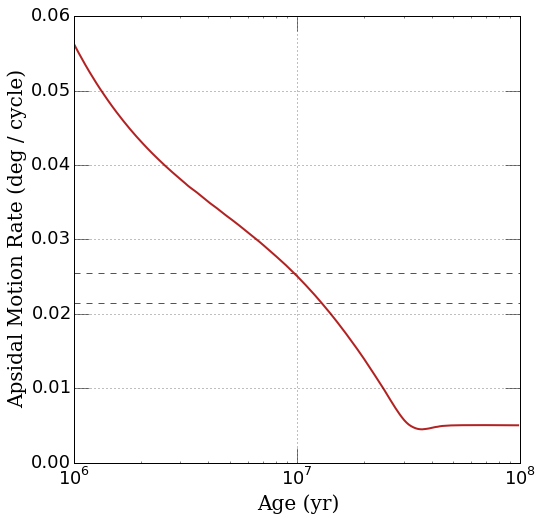

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8., 8.), sharex=True)

ax.grid(True)
ax.tick_params(which='major', axis='both', length=15., labelsize=18.)
ax.set_xlabel('Age (yr)', fontsize=20., family='serif')
ax.set_ylabel('Apsidal Motion Rate (deg / cycle)', fontsize=20., family='serif')
ax.plot([1.0e6, 1.0e8], [0.0215, 0.0215], '--', lw=1, c='#555555')
ax.plot([1.0e6, 1.0e8], [0.0255, 0.0255], '--', lw=1, c='#555555')
ax.semilogx(cl_apsidal_motion_rate[:, 0], cl_apsidal_motion_rate[:, 1], '-', lw=2, c='#b22222')

How sensitive is this to the properties of the A component, which are fairly uncertain?

In [17]:
icurve = interp1d(cl_apsidal_motion_rate[:,1], cl_apsidal_motion_rate[:,0], kind='linear')
print icurve(0.0235)/1.0e6, icurve(0.0255)/1.0e6, icurve(0.0215)/1.0e6

11.2030404132 9.66153795127 12.8365039818


From the classical apsidal motion rate, we might estimate the age of the system to be $11.2 \pm 1.6\ {\rm Myr}$.